In [1]:
from pyspark import SparkContext
sc = SparkContext(master = 'local')

from pyspark.sql import SparkSession
spark = SparkSession.builder \
          .appName("Python Spark SQL basic example") \
          .config("spark.some.config.option", "some-value") \
          .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/03 15:20:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/03 15:20:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
cuse = spark.read.csv('data/alb_homes.csv', header=True, inferSchema=True).select("finsqft","totalvalue")
cuse.show(5)

+-------+----------+
|finsqft|totalvalue|
+-------+----------+
|   1254|    124300|
|   1192|    109200|
|    881|    141600|
|    480|     69200|
|    720|    139700|
+-------+----------+
only showing top 5 rows



In [3]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
x=cuse.rdd.map(lambda x: x[0]).collect()
y=cuse.rdd.map(lambda x: x[-1]).collect()

### Dataset with Gamma distribution typically look like below:

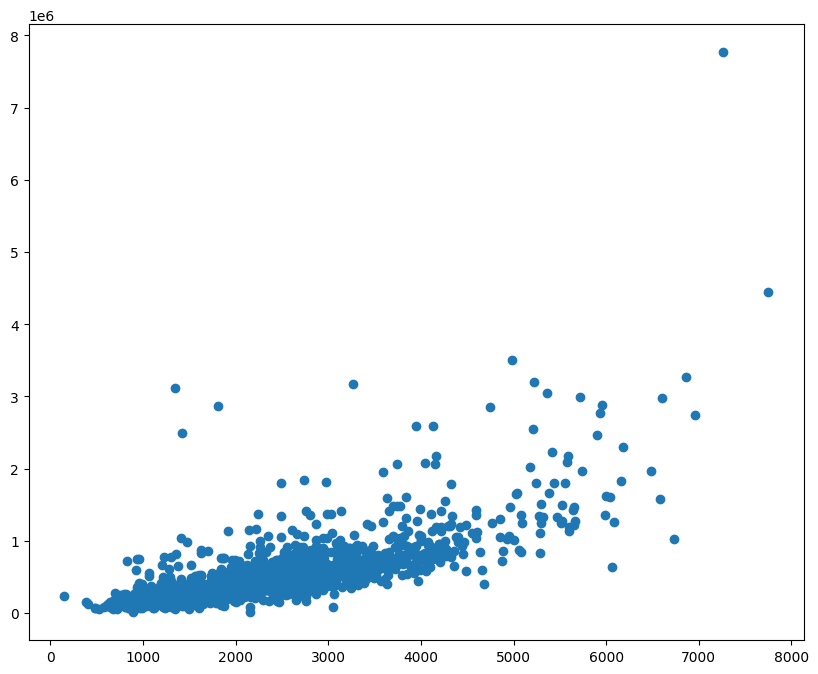

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (10, 8))
plt.scatter(x, y);

In [5]:
cuse=cuse.rdd.map(lambda x: [Vectors.dense(x[0]), x[-1]]).toDF(["features", "label"])
cuse.show(5)



+--------+------+
|features| label|
+--------+------+
|[1254.0]|124300|
|[1192.0]|109200|
| [881.0]|141600|
| [480.0]| 69200|
| [720.0]|139700|
+--------+------+
only showing top 5 rows



In [6]:
# assemble all feature columns into on single vector column
#from pyspark.ml.feature import VectorAssembler
#assembler = VectorAssembler(inputCols=['x'], outputCol='features')
#cuse_df_2 = assembler.transform(cuse).withColumnRenamed('y', 'label')
cuse_df_2=cuse
cuse_df_2.show(5)

+--------+------+
|features| label|
+--------+------+
|[1254.0]|124300|
|[1192.0]|109200|
| [881.0]|141600|
| [480.0]| 69200|
| [720.0]|139700|
+--------+------+
only showing top 5 rows



In [7]:
# split data into training and test datasets
training, test = cuse_df_2.randomSplit([0.8, 0.2], seed=1234)
training.show(5)


+--------+------+
|features| label|
+--------+------+
| [144.0]|228800|
| [406.0]|122700|
| [480.0]| 66200|
| [528.0]| 54800|
| [576.0]| 82000|
+--------+------+
only showing top 5 rows



In [8]:
## ======= build cross validation model ===========

# estimator
from pyspark.ml.regression import GeneralizedLinearRegression
glm = GeneralizedLinearRegression(featuresCol='features', labelCol='label', family='gamma')

# parameter grid
from pyspark.ml.tuning import ParamGridBuilder
param_grid = ParamGridBuilder().\
    addGrid(glm.regParam, [0, 0.5, 1, 2, 4]).\
    build()
    
# evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction')

# build cross-validation model
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=glm, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=4)

In [9]:
# fit model
cv_model = cv.fit(training)
#cv_model = cv.fit(cuse_df_2)

23/05/03 15:21:39 WARN Instrumentation: [0fd5ed63] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:21:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/03 15:21:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/05/03 15:21:39 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/05/03 15:21:39 WARN Instrumentation: [0fd5ed63] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:21:44 WARN Instrumentation: [f1d4a199] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:21:44 WARN Instrumentation: [f1d4a199] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:21:47 WARN Instrumentation: [48d328c2] regParam is zero, which might cause numerical instability and overfitting.


In [10]:
# prediction
#pred_training_cv = cv_model.transform(training)
pred_test_cv = cv_model.transform(test)

#pred_training_cv.show(5)
pred_test_cv.show(5, truncate=False)

+--------+------+------------------+
|features|label |prediction        |
+--------+------+------------------+
|[384.0] |153000|193459.4238168996 |
|[480.0] |69200 |198208.05872303894|
|[704.0] |198000|210249.85809768742|
|[720.0] |139700|211166.21886477186|
|[720.0] |185000|211166.21886477186|
+--------+------+------------------+
only showing top 5 rows



In [11]:
cv_model.bestModel.coefficients

DenseVector([-0.0])

In [12]:
cv_model.bestModel.intercept

5.664398750805046e-06

In [13]:
#cv_model.bestModel

In [15]:
#evaluator.evaluate(pred_training_cv)

In [16]:
evaluator.evaluate(pred_test_cv)

1.0

In [17]:
X=[]
for i in pred_test_cv.rdd.map(lambda x: [x[0][0]]).collect():
    X.append(i[0])
L=[]

for i in pred_test_cv.rdd.map(lambda x: [x[1]]).collect():
    L.append(i[0])
P=[]
for i in pred_test_cv.rdd.map(lambda x: [x[2]]).collect():
    P.append(i[0])


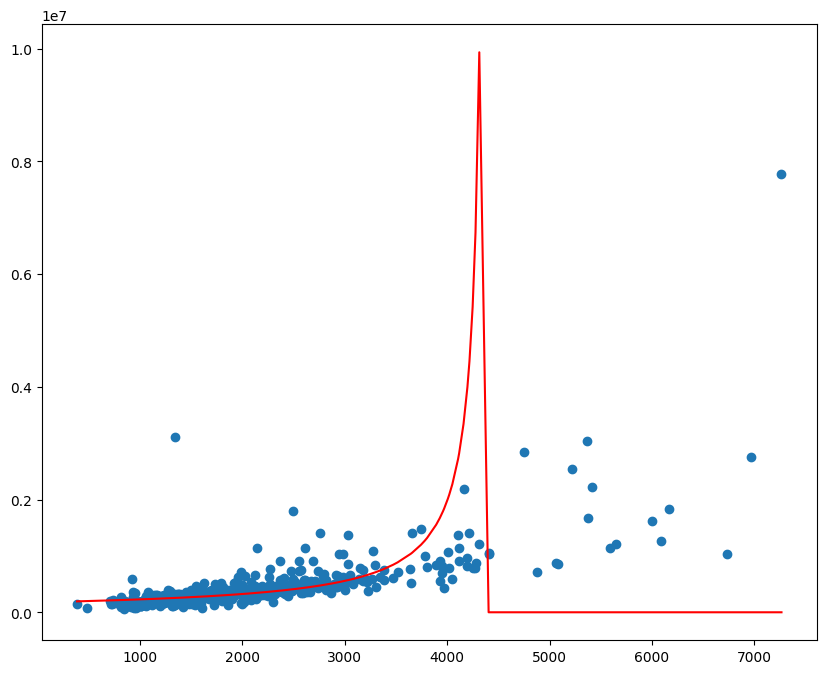

In [18]:
plt.figure(figsize = (10, 8))
plt.scatter(X, L);
plt.plot(X, P,'r-');

In [19]:
## ======= build cross validation model ===========

# estimator
from pyspark.ml.regression import GeneralizedLinearRegression
glm = GeneralizedLinearRegression(featuresCol='features', labelCol='label', family='tweedie')

# parameter grid
from pyspark.ml.tuning import ParamGridBuilder
param_grid = ParamGridBuilder().\
    addGrid(glm.regParam, [0, 0.5, 1, 2, 4]).\
    build()
    
# evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction')

# build cross-validation model
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=glm, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=4)

In [20]:
# fit model
cv_model = cv.fit(training)
#cv_model = cv.fit(cuse_df_2)

23/05/03 15:23:10 WARN Instrumentation: [b8a5110e] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:23:11 WARN Instrumentation: [393f04d3] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:23:13 WARN Instrumentation: [8f2d410f] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:23:14 WARN Instrumentation: [d7b01250] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:23:15 WARN Instrumentation: [0e9b12de] regParam is zero, which might cause numerical instability and overfitting.


In [21]:
# prediction
#pred_training_cv = cv_model.transform(training)
pred_test_cv = cv_model.transform(test)

#pred_training_cv.show(5)
pred_test_cv.show(5, truncate=False)

+--------+------+-------------------+
|features|label |prediction         |
+--------+------+-------------------+
|[384.0] |153000|-40865.44149056918 |
|[480.0] |69200 |-14231.154739151243|
|[704.0] |198000|47915.51434749065  |
|[720.0] |139700|52354.562139393645 |
|[720.0] |185000|52354.562139393645 |
+--------+------+-------------------+
only showing top 5 rows



In [22]:
cv_model.bestModel.coefficients

DenseVector([277.4405])

In [23]:
cv_model.bestModel.intercept

-147402.588496241

In [24]:
#evaluator.evaluate(pred_training_cv)

In [25]:
evaluator.evaluate(pred_test_cv)

1.0

In [26]:
X=[]
for i in pred_test_cv.rdd.map(lambda x: [x[0][0]]).collect():
    X.append(i[0])
L=[]

for i in pred_test_cv.rdd.map(lambda x: [x[1]]).collect():
    L.append(i[0])
P=[]
for i in pred_test_cv.rdd.map(lambda x: [x[2]]).collect():
    P.append(i[0])


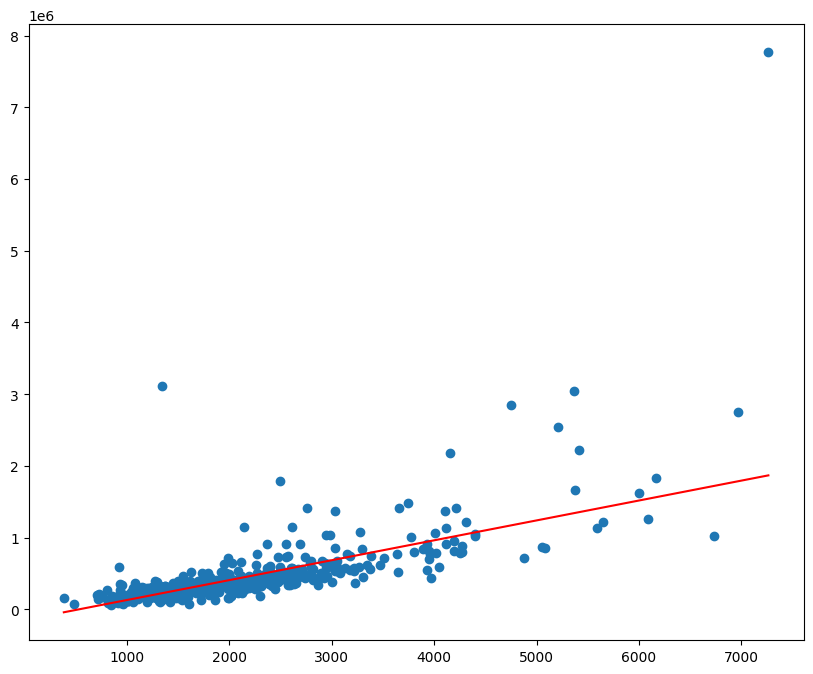

In [27]:
plt.figure(figsize = (10, 8))
plt.scatter(X, L);
plt.plot(X, P,'r-');

In [28]:
## ======= build cross validation model ===========

# estimator
from pyspark.ml.regression import GeneralizedLinearRegression
glm = GeneralizedLinearRegression(featuresCol='features', labelCol='label', family='poisson')

# parameter grid
from pyspark.ml.tuning import ParamGridBuilder
param_grid = ParamGridBuilder().\
    addGrid(glm.regParam, [0, 0.5, 1, 2, 4]).\
    build()
    
# evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction')

# build cross-validation model
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=glm, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=4)

In [29]:
# fit model
cv_model = cv.fit(training)
#cv_model = cv.fit(cuse_df_2)

23/05/03 15:24:13 WARN Instrumentation: [ae3b410d] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:24:13 WARN Instrumentation: [ae3b410d] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:24:13 WARN Instrumentation: [ae3b410d] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:24:13 WARN Instrumentation: [ae3b410d] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:24:13 WARN Instrumentation: [ae3b410d] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:24:15 WARN Instrumentation: [2e1627af] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:24:15 WARN Instrumentation: [2e1627af] regParam is zero, which might cause numerical instability and overfitting.
23/05/03 15:24:15 WARN Instrumentation: [2e1627af] regParam is zero, which might cause numerical instability and overf

In [30]:
# prediction
#pred_training_cv = cv_model.transform(training)
pred_test_cv = cv_model.transform(test)

#pred_training_cv.show(5)
pred_test_cv.show(5, truncate=False)

+--------+------+------------------+
|features|label |prediction        |
+--------+------+------------------+
|[384.0] |153000|175285.18741960675|
|[480.0] |69200 |183163.60438162897|
|[704.0] |198000|202951.26543252653|
|[720.0] |139700|204443.86885653355|
|[720.0] |185000|204443.86885653355|
+--------+------+------------------+
only showing top 5 rows



In [31]:
cv_model.bestModel.coefficients

DenseVector([0.0005])

In [32]:
cv_model.bestModel.intercept

11.898307662600265

In [33]:
#evaluator.evaluate(pred_training_cv)

In [34]:
evaluator.evaluate(pred_test_cv)

1.0

In [35]:
X=[]
for i in pred_test_cv.rdd.map(lambda x: [x[0][0]]).collect():
    X.append(i[0])
L=[]

for i in pred_test_cv.rdd.map(lambda x: [x[1]]).collect():
    L.append(i[0])
P=[]
for i in pred_test_cv.rdd.map(lambda x: [x[2]]).collect():
    P.append(i[0])


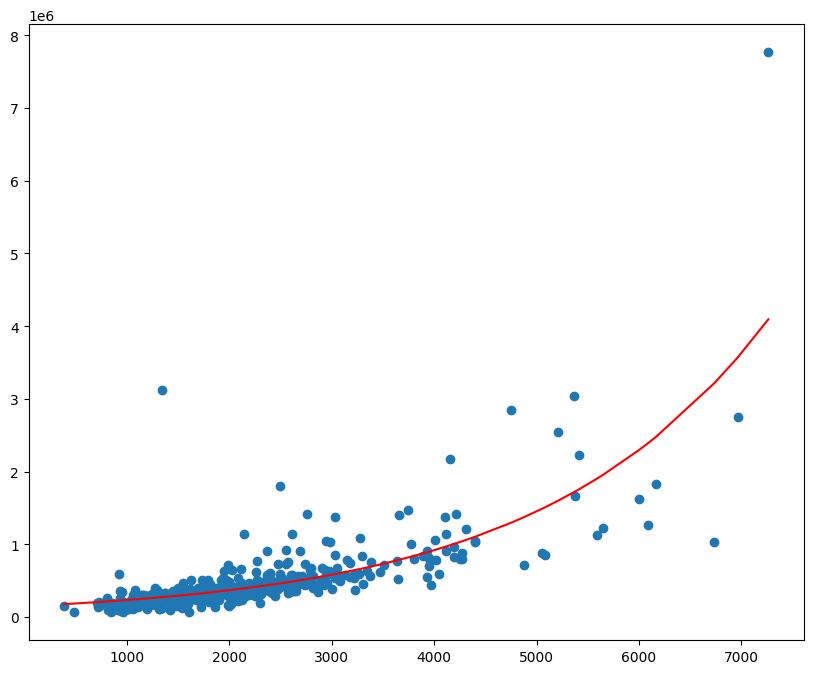

In [36]:
plt.figure(figsize = (10, 8))
plt.scatter(X, L);
plt.plot(X, P,'r-');